# **Defending the Edge: Quality of Block Index**
proposing a mathematical basis for analysing and rating quality of play of Offensive Tackles against the Edge. Additional analysis is conveyed in relating the quality of play in the NFL to results from the NFL Combine. 

QBI is one of three proposed measures to gauge OT play against the Edge. 1. QBI, 2. Blocking Cohesion, 3. Time on Block. An overall score is generated for each OT based on these three measures. Herein is presented the algorithm for calculating QBI, Blocking Cohesion and Time on Block. These are combined into the QBI Metric, and the Block Metric which takes Cohesion and Time to generate a score which is added to the QBI to give an overall score. 

QBI + BM = Score

Data was aggregated by the <a href="https://colab.research.google.com/drive/1nPgD7U6zJIHLGlonTdbDhq3ApHCcMFCM?usp=sharing">OT_Defending_The_Edge_Metric_Aggregation.ipynb</a> notebook file



In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib.animation import writers
import os


#%matplotlib inline

In [ ]:
# Import from GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/"
save_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/charts/"
#if on kaggle
#data_dir = "/kaggle/input/nfl-big-data-bowl-2023/"

'''
data_dir = "../input/metrics-databowl-v2/original_databowl.db"
OUTPUT_DIR = './'
'''

Mounted at /content/gdrive


'\ndata_dir = "../input/metrics-databowl-v2/original_databowl.db"\nOUTPUT_DIR = \'./\'\n'

In [ ]:
import sqlite3

# Create a SQL connection to a local SQLite database
con = sqlite3.connect(data_dir + "original_databowl.db")

In [ ]:
#look up the week by gameId

def get_week_by_gameId(game_id): 
    
    sql = "SELECT week FROM games WHERE (games.gameId=" + str(game_id) + ")"
    query = pd.read_sql_query(sql, con)
    for index, row in query.iterrows():
        week = row["week"]
        
        

    return week
'''
#Testing

week_test = get_week_by_gameId(2021090900)
print(week_test)
'''

'\n#Testing\n\nweek_test = get_week_by_gameId(2021090900)\nprint(week_test)\n'

# **Measuring Euclidean Distance**

the Euclidean distance between two points in Euclidean space is the length of a line segment between the two points.

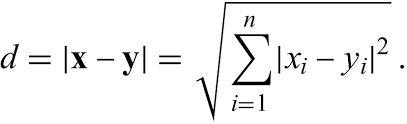



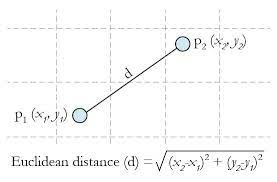

I use the euclidean distance between QB and OT, and for QB and DE as a metric for pressure on the Quarterback and for other metrics, for instance 'time on block' of OT on DE, measuring the (d) over a time series. Block Cohesion also ustilized Euclidean distance (d). 

In [ ]:
def get_distance(p, q):
    """ 
    Return euclidean distance between points p and q
    assuming both to have the same number of dimensions
    p is a tuple of x,y coords ie Offensive Tackle (OT)
    q is a tuple of x,y coords ie Defensive End (DE)
    """
    # sum of squared difference between coordinates
    s_sq_difference = 0
    for p_i,q_i in zip(p,q):
        s_sq_difference += (p_i - q_i)**2
    
    # take sq root of sum of squared difference
    distance = s_sq_difference**0.5
    return distance

# check the function
OT = (2, 3)
DE = (5, 7)
# distance b/w a and b
d = get_distance(OT, DE)
# display the result
print(d)

#https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
from scipy.spatial import distance
res = distance.euclidean(OT, DE)
print(res)

5.0
5.0


**Various Lookup and Measuring Functions**

In [ ]:
def combine_to_active_roster():
    #gets a list of OT in players table that match a row in combine table 
    sql = """
           select * from players as p, combine as c where p.officialPosition = 'T' and c.Name = p.displayName
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

OT_in_league = combine_to_active_roster()
#print(OT_in_league)



def player_xy(week, nfl_id, game_id, play_id):
    # get the x,y,pos,etc for the OT by nflId
    #  select * from week1 as wk where wk.nflId = 42377
 
    sql = """
           select * from week""" + str(week) + """ as wk where wk.nflId = """ + str(nfl_id) + """ 
           AND gameId = """ + str(game_id) + """ 
           AND playId = """ + str(play_id) + """ 
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query




def player_scouting(nfl_id):
    #get hits, missed blocks, etc for the OT by nflId, gameId, playId
    #  select * from pffScoutingData where nflId = 42377 
 
    sql = """
           select * from pffScoutingData as pff where pff.nflId = """ + str(nfl_id) + """  
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query



def player_scouting_by_play(nfl_id, game_id, play_id):
    #get hits, missed blocks, etc for the OT by nflId, gameId, playId
    #  select * from pffScoutingData where nflId = 42377 
 
    sql = """
           select * from pffScoutingData as pff where pff.nflId = """ + str(nfl_id) + """ 
           AND pff.gameId = """ + str(game_id) + """ 
           AND pff.playId = """ + str(play_id) + """ 
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query



def player_xy_by_play(week, nfl_id, game_id, play_id):
    
    #get x,y,pos, etc for the blocked player by OT
    #  select * from week1 where nflId = 42403 AND playId = 97 and gameId = 2021090900 #nflId is the pffScoutingData.pff_nflIdBlockedPlayer
 
    sql = """
           select * from week""" + str(week) + """ where nflId = """+ str(nfl_id) + """
            AND playId = """ + str(play_id) + """
             and gameId = """ + str(game_id) + """ 
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query



def qb_for_play(game_id, play_id):
    #get hits, missed blocks, etc for the OT by nflId, gameId, playId
    #  select * from pffScoutingData where nflId = 42377 
 
    sql = """
           select * from pffScoutingData as pff where pff.pff_role = 'Pass' 
           AND pff.gameId = """ + str(game_id) + """ 
           AND pff.playId = """ + str(play_id) + """ 
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query


def plays_tracking_by_OT(nfl_id):

    sql = """
           select DISTINCT wk.gameId, wk.playId from weeks as wk WHERE wk.nflId = """ + str(nfl_id) + """ 

    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query


def defenseId_by_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT(pff.pff_nflIdBlockedPlayer) from pffScoutingData as pff, weeks as wk where  pff.nflId = wk.nflId 
           and wk.nflId = """ + str(nfl_id) + """ 
           and wk.gameId =  """ + str(game_id) + """ 
           and wk.playId = """ + str(play_id) + """ 
           and wk.playId = pff.playId 
           and wk.gameId = pff.gameId
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def qbId_by_play(game_id, play_id):

    sql = """
           select pff.nflId from pffScoutingData as pff where pff.pff_role = 'Pass'  
           and pff.gameId =  """ + str(game_id) + """ 
           and pff.playId =  """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query



#get tracking data for each play by passResult
def get_player_tracking_limit(nfl_id, game_id, play_id, week, event):
    #game_id (int), play_id (int),  week (int), event: pass_forward, ball_snap
    sql = """select rowid from week""" + str(week) + """ as wk 
             where wk.gameid = """ + str(game_id) + """  
             AND wk.playId = """ + str(play_id) + """ 
             AND wk.nflId = """ + str(nfl_id) + """
             AND wk.event = '""" + event + """'
          """
    #print(sql)
    query = pd.read_sql_query(sql, con) 
    result = query['rowid'].tolist()
    #sometimes there are data errors missing 'pass_forward' or 'ball_snap' skip those plays
    if len(result) == 0:
        return None

    result = result[0]
    return result




#get tracking data for each play by passResult
def get_player_relevant_tracking_data(nfl_id, game_id, play_id, week, lower_bounds, upper_bounds):
    #game_id (int), play_id (int), team (str) i.e. 'TB', week (int), pass_result (int; 0,1), lower_bounds (int), upper_bounds (int)
    #upper = upper_bounds - lower_bounds + 1
    upper_bounds = upper_bounds - lower_bounds
    upper = upper_bounds + 1
    lower = 6 - 1
    sql = """select wk.playId, wk.gameId, wk.nflId, wk.frameId, wk.time, wk.x, 
             wk.y, wk.s, wk.a, wk.dis, wk.o, wk.dir, wk.event from week""" + str(week) + """ as wk 
             where wk.gameid = """ + str(game_id) + """ 
             AND wk.playId = """ + str(play_id) + """ 
             AND wk.nflId = """ + str(nfl_id) + """   
             AND wk.team != 'football' 
             LIMIT """+str(lower)+""","""+str(upper)+"""              
          """
    #print(sql)
    query = pd.read_sql_query(sql, con)
    
    return query


def add_metric(metric):
    print(type(metric))
    print(len(metric))
    for cnt,j in enumerate(metric):
      for rec in j.iterrows():
        game_id = rec[1]['gameId']
        play_id = rec[1]['playId']
        nfl_id = rec[1]['nflId']
        frame_id = rec[1]['frameId']
        time = rec[1]['time']
        x = rec[1]['x']
        y = rec[1]['y']
        s = rec[1]['s']
        a = rec[1]['a']
        dis = rec[1]['dis']
        o = rec[1]['o']
        dir = rec[1]['dir']
        
        cursor = con.cursor()
        sql = "INSERT INTO `clipped_tracking` (`nflId`, `gameId`, `playId`, `frameId`, `time`, `x`, `y`, `s`, `a`, `dis`, `o`, `dir` ) VALUES (" + str(nfl_id) + "," + str(game_id) + "," + str(play_id) + "," + str(frame_id) + ", '" + str(time) + "',"  + str(x) + ", " + str(y) + ", " + str(s) + "," + str(a) + "," + str(dis) + "," + str(o) + "," + str(dir) + ")"
        # Execute the query
        cursor.execute(sql)
        # the connection is not autocommited by default. So we must commit to save our changes.
        con.commit()
      


######################## END FUNCTIONS FOR TRACKING AND METRICS ###############################################




**Basic Metrics Functions**

In [ ]:
def blocker_metrics(nfl_id):
    sql = """
           select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def plays_to_events(nfl_id, event):
    #nfl_id is the nflId of the blocker, here Offensive Tackle (OT)
    #event is the metric: pff_beatenByDefender, pff_hitAllowed, pff_hurryAllowed, pff_sackAllowed =1, 'none' is where all = 0
    event_plays = [] # a list for plays for given event
    
    if event == 'pff_beatenByDefender':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """
              AND pff.pff_beatenByDefender = 1  
        """  
        beatenByDefender_query = pd.read_sql_query(sql, con)
        for i,r in beatenByDefender_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)


    if event == 'pff_hitAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hitAllowed = 1 
        """  
        hitAllowed_query = pd.read_sql_query(sql, con)
        for i,r in hitAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    if event == 'pff_hurryAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hurryAllowed = 1 
        """  
        hurryAllowed_query = pd.read_sql_query(sql, con)
        for i,r in hurryAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    if event == 'pff_sackAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_sackAllowed = 1 
        """  
        #print(sql)
        sackAllowed_query = pd.read_sql_query(sql, con)
        for i,r in sackAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)
        
    if event == 'none':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hitAllowed = 0 
              AND pff.pff_hurryAllowed = 0 
              AND pff.pff_sackAllowed = 0 
              AND pff.pff_beatenByDefender = 0 
        """  
        none_query = pd.read_sql_query(sql, con)
        for i,r in none_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    return event_plays




def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    return (str1.join(s))

def player_tracking_clipped(nfl_id, game_id, play_id):

    sql = """
           select * from weeks as wk WHERE wk.nflId = """ + str(nfl_id) + """ 
           AND  wk.gameId = """ + str(game_id) + """ 
           AND  wk.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def combine_results(nfl_id):
    name_sql = """
           select p.displayName from players as p WHERE p.nflId = """ + str(nfl_id) + """ 
            
    """  
    name = pd.read_sql_query(name_sql, con)
    name = name.values.tolist()
    for n in name:
      player_name = n
      player_name = listToString(player_name)
      player_name = player_name.replace("'", " " )

    sql = """
           select * from combine as c WHERE c.Name = '""" + str(player_name) + """' 
            
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def player_role(nfl_id):

    sql = """
           select pff_positionLinedUp from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def metric_euclidean(offense_tracking, defender_tracking):
    #reference 1 variables, usually offensive player    
    x_y_coords = offense_tracking[['x', 'y']]
    records = x_y_coords.to_records(index=False)
    result = list(records)
    x_y_coords_list = result
    reference1_id = offense_tracking.iloc[0]['nflId']
    game_id = offense_tracking.iloc[0]['gameId']
    play_id = offense_tracking.iloc[0]['playId']
    ref1_role = player_role(reference1_id) #make a lookup of pff_position
    ref1_role = ref1_role.iloc[0]['pff_positionLinedUp']
    ref1_acceleration = offense_tracking['a'].max() 
    ref1_yards = offense_tracking['dis'].sum()
    ref1_avg_speed = offense_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed
    play_length = len(offense_tracking) * .1 #sum of frames



    #reference 2 variables, usually defender
    x_y_coords_defender = defender_tracking[['x', 'y']]
    defender_records = x_y_coords_defender.to_records(index=False)
    defender_result = list(defender_records)
    defender_x_y_coords_list = defender_result
    reference2_id = defender_tracking.iloc[0]['nflId']
    ref2_role = player_role(reference2_id) #make a lookup of pff_position
    ref2_role = ref2_role.iloc[0]['pff_positionLinedUp']
    ref2_acceleration = defender_tracking['a'].max() 
    ref2_yards = defender_tracking['dis'].sum() #sum(dis), alter table ref1 yards, ref2 yards
    ref2_avg_speed = defender_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed



    for c,k in enumerate(defender_x_y_coords_list):
      reference1_x = x_y_coords_list[c][0]
      reference1_y = x_y_coords_list[c][1]
      ref1_tuple = x_y_coords_list[c]
      reference2_x = defender_x_y_coords_list[c][0]
      reference2_y = defender_x_y_coords_list[c][1]
      ref2_tuple = defender_x_y_coords_list[c]
      euclidian_distance = get_distance(ref1_tuple, ref2_tuple)
    
      # Create a new record
      cursor = con.cursor()
      sql = "INSERT INTO `frame_metrics` (`reference1_id`, `reference2_Id`, `reference1_x`, `reference1_y`, `gameId`, `playId`, `ref1_role`, `ref2_role`, `reference2_x`, `reference2_y`, `euclidean`, `ref1_acceleration`, `ref2_acceleration`, `ref1_yards`, `ref2_yards`, `ref1_avg_speed`, `ref2_avg_speed`, `play_length`) VALUES (" + str(reference1_id) + ", " + str(reference2_id) + ", " + str(reference1_x) +", " + str(reference1_y) + ", " + str(game_id) + ", " + str(play_id) + ", '" + ref1_role + "', '" + ref2_role + "', " + str(reference2_x) + ", " + str(reference2_y) + ", " + str(euclidian_distance) + ", " + str(ref1_acceleration) + "," + str(ref2_acceleration) + ", " + str(ref1_yards) + "," + str(ref2_yards) + ", " + str(ref1_avg_speed) + ", " + str(ref2_avg_speed) + "," + str(play_length) + ")"         
      print(sql)
      # Execute the query
      cursor.execute(sql)
      # the connection is not autocommited by default. So we must commit to save our changes.
      con.commit()
                
def convert_yds_to_mph(seconds, distance):    
    d_ft = distance * 3
    d_inches = d_ft * 12
    d_yards = d_ft / 3.0
    d_miles = d_ft / 5280.0
    miles = print("Input distance in miles ", d_miles)

    hours=float(seconds)/3600
    mph = float(d_miles)/seconds*3600
    return(mph)

def get_clipped_nflids_OT(): 
    sql = """
           select DISTINCT(wk.nflId) from pffScoutingData as pff, weeks as wk where pff.pff_positionLinedUp IN ('LT', 'RT') 
AND pff.nflId = wk.nflId  
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query




################## END Function Definitions ####################################



# **Basic Metrics from PffScoutingData**


4 Base Metrics: beatenByDefender, hitAllowed, hurryAllowed, sackAllowed

In [ ]:
#how much weight to put on each of the different metric events, sack is more damaging then hurry, etc. 
clipped_nflids = get_clipped_nflids_OT()

nfl_ids = clipped_nflids[['nflId']]
print(nfl_ids)

for c,r in nfl_ids.iterrows():
  player_id = r['nflId']
  player_metric = blocker_metrics(player_id)
  if(len(player_metric) >= 1):
    #get total (sum) of 4 metrics tracked by pff for OL in pffScoutingData table
    beaten_by_defender = player_metric['pff_beatenByDefender'].sum()
    hit_allowed = player_metric['pff_hitAllowed'].sum()
    hurry_allowed = player_metric['pff_hurryAllowed'].sum()
    sack_allowed = player_metric['pff_sackAllowed'].sum()
    #get [gameId, playId, pff_nflIdBlockedPlayer] returned in a list for each metric event
    beaten_plays = plays_to_events(player_id, 'pff_beatenByDefender')
    hit_plays = plays_to_events(player_id, 'pff_hitAllowed')
    hurry_plays = plays_to_events(player_id, 'pff_hurryAllowed')
    sack_plays = plays_to_events(player_id, 'pff_sackAllowed')
    combine_performance = combine_results(player_id)
    #display metrics for each player
    print()
    print("-------------------------------------------------------")
    print(c)
    print("Player Metrics: ", r['nflId'])
    print("Combine Performance: ", combine_performance)
    print()
    print("Total Plays: ", len(player_metric))
    print("Fouls Committed: ")
    print("beaten by defender: ", beaten_by_defender, beaten_plays)
    print("hit allowed: ", hit_allowed, hit_plays)
    print("hurry allowed: ", hurry_allowed, hurry_plays)
    print("sack allowed: ", sack_allowed, sack_plays)

    print()


#TODO: add accounting for penalties, penalty yards, etc. is there a model for holding

       nflId
0    42377.0
1    52421.0
2    37082.0
3    42654.0
4    41232.0
..       ...
119  48158.0
120  39983.0
121  44970.0
122  53868.0
123  52516.0

[124 rows x 1 columns]

-------------------------------------------------------
0
Player Metrics:  42377.0
Combine Performance:              Name Pos      School        College   Ht     Wt  40yd  Vertical  \
0  Donovan Smith  OT  Penn State  College Stats  6-6  338.0  5.27      32.0   

   Bench  Broad Jump  3Cone  Shuttle  \
0   26.0       109.0   7.95     4.79   

                             Drafted (tm/rnd/yr) Player-additional  
0  Tampa Bay Buccaneers / 2nd / 34th pick / 2015          SmitDo02  

Total Plays:  306
Fouls Committed: 
beaten by defender:  12.0 ['2021090900,559,42403.0', '2021091910,1025,42480.0', '2021091910,1754,53611.0', '2021091910,2313,42346.0', '2021091910,2359,42346.0', '2021091910,3564,42346.0', '2021100313,2135,43435.0', '2021100313,2401,43435.0', '2021101007,1914,46307.0', '2021101400,3823,44826.0', '20

# **Modeling of Edge Blocking**



# **frame_metrics table:**
has two references divided up into 3 aspects: ot-to-de, qb-to-ot, qb-to-de

**ot-to-de** is used to measure quality of block index which is to say the amount

of control over the Defensive End by the Offensive Tackle

**qb-to-ot** is used to measure how far the OT remains from the QB

**qb-to-de** is used to measure how far the DE remains from the QB and whether he enters the safe zone around the quarter back 1.5 yds, then there is the reach zone which is <1.0 yds around the QB, and of course the death zone which is <.7 yds from the QB. 

All measured by Euclidean distance. 

# **Test Bed for Select Plays to Verify Rating Model**

In [ ]:
def game_frames(reference1_id, reference2_id, game_id, play_id):

    sql = """
           select * from frame_metrics as fm WHERE fm.reference1_id = """ + str(reference1_id) + """ 
           AND  fm.reference2_id = """ + str(reference2_id) + """ 
           AND  fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def ids_for_frames(game_id, play_id):

    sql = """
           select DISTINCT reference1_id, reference2_id, ref1_role, ref2_role from frame_metrics as fm WHERE fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query


#need to get OT plays per game, then blockedPlayer for play and QB for play
#make sure to limit frame count to <= 3.5seconds

#redo this to get individual dataframes for each row, head 6, tail 6, combine wk1-8 into tracking table

#get listing of unique blocker nflIds,
#clipped_nflids = get_clipped_nflids_OT()
#nfl_ids = clipped_nflids[['nflId']]
#print(nfl_ids)

#ids = ids_for_frames(2021090900, 97)
#display(ids)


print() 
print("------------------- NORMAL -------------------------")
print()

player_tracking_for_play = game_frames(42377, 42403, 2021090900, 456)
qb_tracking_offense = game_frames(25511, 42377, 2021090900, 456)
qb_tracking_defense = game_frames(25511, 42403, 2021090900, 456)

#player_tracking = player_tracking_clipped(42377, 2021090900, 97)
#print(player_tracking_for_play)
df_len = len(player_tracking_for_play)
df_limit_456 = df_len - 5



block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_456 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("Play 456")
display(rating_data_456[5:df_limit_456])


print()

player_tracking_for_play = game_frames(42377, 46185, 2021090900, 480)
qb_tracking_offense = game_frames(25511, 42377, 2021090900, 480)
qb_tracking_defense = game_frames(25511, 46185, 2021090900, 480)

df_len = len(player_tracking_for_play)
df_limit_480 = df_len - 5

print() 

block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_480 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("Play 480")
display(rating_data_480[5:df_limit_480])

print()

player_tracking_for_play = game_frames(42377, 46185, 2021090900, 509)
qb_tracking_offense = game_frames(25511, 42377, 2021090900, 509)
qb_tracking_defense = game_frames(25511, 46185, 2021090900, 509)

#player_tracking = player_tracking_clipped(42377, 2021090900, 97)
#print(player_tracking_for_play)
df_len = len(player_tracking_for_play)
df_limit_509 = df_len - 5

print() 

block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_509 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("Play 509")
display(rating_data_509[5:df_limit_509])






print()
print("--------------------------------- HURRY ---------------------------------------------")
print()


player_tracking_for_play = game_frames(42377, 42403, 2021090900, 97)
qb_tracking_offense = game_frames(25511, 42377, 2021090900, 97)
qb_tracking_defense = game_frames(25511, 42403, 2021090900, 97)

#player_tracking = player_tracking_clipped(42377, 2021090900, 97)
#print(player_tracking_for_play)
df_len = len(player_tracking_for_play)
df_limit_97 = df_len - 5

print() 

block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_97 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("Play 97 Hurry")
display(rating_data_97[5:df_limit_97])

print()



player_tracking_for_play_925 = game_frames(42377, 46185, 2021090900, 925)
qb_tracking_offense_925 = game_frames(25511, 42377, 2021090900, 925)
qb_tracking_defense_925 = game_frames(25511, 46185, 2021090900, 925)

df_len = len(player_tracking_for_play_925)
df_limit_925 = df_len - 5

block_metrics = player_tracking_for_play_925[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_925[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_925[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_925 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 925 Hurry")
display(rating_data_925[5:df_limit_925])



player_tracking_for_play_2915 = game_frames(42377, 42403, 2021090900, 2915)
qb_tracking_offense_2915 = game_frames(25511, 42377, 2021090900, 2915)
qb_tracking_defense_2915 = game_frames(25511, 42403, 2021090900, 2915)

df_len = len(player_tracking_for_play_2915)
df_limit_2915 = df_len - 5

block_metrics = player_tracking_for_play_925[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_925[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_925[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_2915 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 2915 Hurry")
display(rating_data_2915[5:df_limit_2915])



print()
print("------------------------------ SACKS ------------------------------------------------")
print()



player_tracking_for_play_508 = game_frames(42377, 42346, 2021091910, 508)
qb_tracking_offense_508 = game_frames(25511, 42377, 2021091910, 508)
qb_tracking_defense_508 = game_frames(25511, 42346, 2021091910, 508)

df_len = len(player_tracking_for_play_508)
df_limit_508 = df_len - 5

block_metrics = player_tracking_for_play_508[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_508[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_508[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_508 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 508 Sack")
display(rating_data_508[5:df_limit_508])




print()
print("------------------------------------ HITS ------------------------------------------")
print()



player_tracking_for_play_4057 = game_frames(42377, 52492, 2021092611, 4057)
qb_tracking_offense_4057 = game_frames(25511, 42377, 2021092611, 4057)
qb_tracking_defense_4057 = game_frames(25511, 52492, 2021092611, 4057)

df_len = len(player_tracking_for_play_4057)
df_limit_4057 = df_len - 5

block_metrics = player_tracking_for_play_4057[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_4057[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_4057[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_4057 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 4057 hit on qb")
display(rating_data_4057[5:df_limit_4057])

print()

#2021100313,780,43435.0
player_tracking_for_play_780 = game_frames(42377, 43435, 2021100313, 780)
qb_tracking_offense_780 = game_frames(25511, 42377, 2021100313, 780)
qb_tracking_defense_780 = game_frames(25511, 43435, 2021100313, 780)

df_len = len(player_tracking_for_play_780)
df_limit_780 = df_len - 5

block_metrics = player_tracking_for_play_780[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_780[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_780[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_780 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 780 hit on qb")
display(rating_data_780[5:df_limit_780])






print()
print("--------------------------------- BEATEN ---------------------------------------------")
print()



player_tracking_for_play_1025 = game_frames(42377, 42480, 2021091910, 1025)
qb_tracking_offense_1025 = game_frames(25511, 42377, 2021091910, 1025)
qb_tracking_defense_1025 = game_frames(25511, 42480, 2021091910, 1025)

df_len = len(player_tracking_for_play_1025)
df_limit_1025 = df_len - 5

block_metrics = player_tracking_for_play_1025[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_1025[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_1025[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_1025 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 1025 Beaten by Rusher")
display(rating_data_1025[5:df_limit_1025])


print()


player_tracking_for_play_1754 = game_frames(42377, 53611, 2021091910, 1754)
qb_tracking_offense_1754 = game_frames(25511, 42377, 2021091910, 1754)
qb_tracking_defense_1754 = game_frames(25511, 53611, 2021091910, 1754)

df_len = len(player_tracking_for_play_1754)
df_limit_1754 = df_len - 5

block_metrics = player_tracking_for_play_1754[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_1754[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_1754[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_1754 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 1754 Beaten by Rusher")
display(rating_data_1754[5:df_limit_1754])


print()


player_tracking_for_play_2313 = game_frames(42377, 42346, 2021091910, 2313)
qb_tracking_offense_2313 = game_frames(25511, 42377, 2021091910, 2313)
qb_tracking_defense_2313 = game_frames(25511, 42346, 2021091910, 2313)

df_len = len(player_tracking_for_play_2313)
df_limit_2313 = df_len - 5

block_metrics = player_tracking_for_play_2313[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_offense = qb_tracking_offense_2313[['ref1_role', 'ref2_role', 'euclidean']]
qb_metrics_defense = qb_tracking_defense_2313[['ref1_role', 'ref2_role', 'euclidean']]
block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
rating_data_2313 = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

print("play 2313 Beaten by Rusher")
display(rating_data_2313[5:df_limit_2313])
print()



#how to detect if blocked plalyer is point of pressure on QB, and causes the QB to scramble? 

#  https://www.pff.com/news/pro-how-pff-grades-pass-protection



,reference1_id,reference2_id,ref1_role,ref2_role
0,42377,42403,LT,ROLB
1,25511,42377,QB,LT
2,25511,42403,QB,ROLB
3,52421,53441,RT,LILB
4,25511,52421,QB,RT
5,25511,53441,QB,LILB



------------------- NORMAL -------------------------

Play 456


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.850403,4.360275,8.160049
6,3.829204,4.315229,8.105307
7,3.786357,4.249765,8.010306
8,3.736001,4.159327,7.882265
9,3.634020,4.114134,7.741137
10,3.458005,4.084801,7.538554
11,3.304119,4.062635,7.363871
12,3.108504,4.060554,7.166540
13,2.848614,4.085535,6.930007
14,2.607163,4.115264,6.716286




Play 480


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.428309,4.451517,7.830741
6,3.424047,4.434636,7.817013
7,3.420015,4.403317,7.789641
8,3.372314,4.350368,7.699610
9,3.303120,4.263860,7.554846
10,3.183080,4.174829,7.354590
11,3.014249,4.098902,7.113150
12,2.839384,4.026164,6.862864
13,2.652791,3.986289,6.631033
14,2.418347,3.960114,6.363717




Play 509


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,2.894011,4.544722,7.428068
6,2.851614,4.535218,7.377594
7,2.786898,4.545987,7.327592
8,2.687155,4.505874,7.191863
9,2.545624,4.511341,7.056940
10,2.319353,4.562072,6.880763
11,2.107605,4.664343,6.768966
12,1.895046,4.773468,6.666363
13,1.683449,4.918089,6.600485
14,1.457155,5.063161,6.519916



--------------------------------- HURRY ---------------------------------------------


Play 97 Hurry


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,6.241354,4.589466,10.452009
6,6.217025,4.590697,10.450000
7,6.085433,4.592004,10.358002
8,5.926635,4.572800,10.242095
9,5.577966,4.552296,9.912906
10,5.274031,4.528664,9.625352
11,4.942975,4.532560,9.334415
12,4.581703,4.583819,9.044612
13,4.149723,4.637424,8.678301
14,3.734488,4.680278,8.323665



play 925 Hurry


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,2.732398,3.018095,5.380344
6,2.675257,3.014050,5.344390
7,2.633515,3.013785,5.321889
8,2.554858,2.999017,5.268662
9,2.470081,3.004663,5.215908
10,2.384722,3.009867,5.173200
11,2.292597,3.005678,5.098284
12,2.171106,3.008538,5.017669
13,2.036468,3.035951,4.947828
14,1.874913,3.073581,4.862304


play 2915 Hurry


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,2.732398,3.018095,5.380344
6,2.675257,3.014050,5.344390
7,2.633515,3.013785,5.321889
8,2.554858,2.999017,5.268662
9,2.470081,3.004663,5.215908
10,2.384722,3.009867,5.173200
11,2.292597,3.005678,5.098284
12,2.171106,3.008538,5.017669
13,2.036468,3.035951,4.947828
14,1.874913,3.073581,4.862304



------------------------------ SACKS ------------------------------------------------

play 508 Sack


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.028349,4.375774,7.389269
6,2.936154,4.386342,7.311976
7,2.823367,4.384267,7.200694
8,2.702980,4.363542,7.063172
9,2.533871,4.368352,6.901159
10,2.364847,4.348391,6.713107
11,2.155203,4.343328,6.498508
12,1.912067,4.352850,6.264830
13,1.674097,4.356007,6.030008
14,1.445164,4.338502,5.783329



------------------------------------ HITS ------------------------------------------

play 4057 hit on qb


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.087653,4.521427,7.558128
6,3.065371,4.516426,7.536392
7,3.043222,4.511596,7.514659
8,3.022334,4.523196,7.505864
9,2.965822,4.554668,7.483027
10,2.888460,4.580393,7.432039
11,2.804461,4.604085,7.372503
12,2.691505,4.628002,7.285890
13,2.565346,4.646084,7.177722
14,2.438360,4.654557,7.062188



play 780 hit on qb


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.946707,4.411916,8.257027
6,3.913426,4.411916,8.227813
7,3.835948,4.432212,8.177286
8,3.758683,4.469720,8.140424
9,3.645600,4.537059,8.096746
10,3.493265,4.614293,8.018603
11,3.271238,4.730011,7.906478
12,3.007408,4.874474,7.781889
13,2.724849,5.003299,7.631474
14,2.436555,5.099814,7.445891



--------------------------------- BEATEN ---------------------------------------------

play 1025 Beaten by Rusher


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,2.048316,2.953320,2.850070
6,2.039338,2.935524,2.856746
7,2.008009,2.889983,2.849860
8,1.900789,2.810071,2.880434
9,1.780365,2.745633,2.951373
10,1.637834,2.717738,3.066235
11,1.499667,2.698333,3.189545
12,1.309733,2.750455,3.388923
13,1.133225,2.908144,3.627299
14,0.992975,3.148365,3.924513


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


play 1754 Beaten by Rusher


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.695294,4.052468,7.741505
6,3.702999,4.101317,7.792163
7,3.676044,4.172026,7.827880
8,3.642266,4.236567,7.848630
9,3.565347,4.309907,7.832101
10,3.453259,4.398920,7.794261
11,3.347626,4.461177,7.735225
12,3.209143,4.515861,7.640995
13,3.034881,4.571313,7.511724
14,2.818599,4.625884,7.347415



play 2313 Beaten by Rusher


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
5,3.128003,4.392220,7.508928
6,3.128610,4.406200,7.524493
7,3.123348,4.422002,7.538554
8,3.074345,4.454054,7.522991
9,3.003764,4.460717,7.460952
10,2.861748,4.480647,7.340368
11,2.713098,4.487694,7.199951
12,2.549510,4.480737,7.030007
13,2.329485,4.496943,6.826419
14,2.087989,4.542796,6.630754


# **QBI Rating for Each Play**

In [ ]:
def add_data_to_metrics(blocker_id, defender_id, game_id, play_id, buffer, dangerarea, sackarea, def_buffer, def_dangerarea, def_sackarea, beaten, regained, rating):
    #print(write_buffer)

    cursor = con.cursor()
    sql = "INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buffer`, `rush_dangerarea`, `rush_sackarea` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(rating) + ", " + str(beaten) + ","  + str(regained) + ", " + str(buffer) + ", " + str(dangerarea) + "," + str(sackarea) + "," + str(def_buffer) + "," + str(def_dangerarea) + "," + str(def_sackarea) + ")"
    #print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()
    


def rate_play(play_dataframe, blocker_id, defender_id, game_id, play_id):
    penalty = False
    rating = 3
    play_length_unclipped = len(play_dataframe)
    pos = 0
    beaten = False
    regained = False
    penalty_value = 0
    buffer_penalty = False
    def_buffer_penalty = False
    buffer_penalty_value = 0
    def_buffer_penalty_value = 0
    dangerarea_penalty = False
    def_dangerarea_penalty = False
    dangerarea_penalty_value = 0
    def_dangerarea_penalty_value = 0
    sackarea_penalty = False
    def_sackarea_penalty = False
    sackarea_penalty_value = 0
    def_sackarea_penalty_value = 0
    play_dataframe = play_dataframe[5:play_length_unclipped-5]
    play_length = len(play_dataframe)
    
    
    if play_length >= 35:
        play_length = 35 #maximum play length is 3.5 sec, 35 frames
    else:
        play_length = play_length
    
    #print("play length original/clipped: ", play_length_unclipped, play_length)
    for c,i in play_dataframe.iterrows():
        if c > 39:
            break
            
        block_distance = i['block_euclidean']
        qb_blocker_distance = i['qb_blocker_euclidean']
        qb_rusher_distance = i['qb_rusher_euclidean']
        
        #print("row: ", c, qb_blocker_distance, qb_rusher_distance)
        
        rusher_min = qb_rusher_distance
        blocker_min = qb_blocker_distance
        
         
        #  beat by a difference of .01 in euclidean distance is around .33 inches
        #  beat by a difference of .1 in euclidean distance is around 3.6 incehs
        if(qb_rusher_distance < qb_blocker_distance):
            beaten = True
            regained = False
            pos = c
            #print("beaten")
        
        if(qb_rusher_distance > qb_blocker_distance and beaten == True):
            regained = True
            #print("regained control")
         
            
        if rusher_min < 1.5:
            #print("def in buffer zone, subtracting points")
            if def_buffer_penalty == False:
                def_buffer_penalty_value = def_buffer_penalty_value + .5
            def_buffer_penalty = True
            
        if rusher_min < 1.0:
            #print("def in danger area, subtracint points")
            if def_dangerarea_penalty == False:
                def_dangerarea_penalty_value = def_dangerarea_penalty_value + .5
            def_dangerarea_penalty = True
            
        if rusher_min < .7:
            #print("def in sack zone, block zeroed out")
            if def_sackarea_penalty == False:
                def_sackarea_penalty_value = def_sackarea_penalty_value + 3
            def_sackarea_penalty = True
            
    
        if blocker_min < 1.5:
            #print("blocker in buffer zone")
            if buffer_penalty == False:
                buffer_penalty_value = buffer_penalty_value + .5
            buffer_penalty = True
            
        if blocker_min < 1.0:
            #print("blocker in dangerarea")
            if dangerarea_penalty == False:
                dangerarea_penalty_value = dangerarea_penalty_value + .5
            dangerarea_penalty = True
            
    
        if blocker_min < .7:
            #print("blocker in sack/reach zone")
            if sackarea_penalty == False:
                sackarea_penalty_value = sackarea_penalty_value + 3
            sackarea_penalty = True
            
        
        
    if(beaten == True and regained == True):        
        #print("heuristic penalty triggered")
        penalty = True
        penalty_value = .25
    
    if(beaten == True and regained == False):
        penalty = True
        penalty_value = .50
        
    
    #rating = rating - penalty_value
    rating = rating - penalty_value - buffer_penalty_value - dangerarea_penalty_value - sackarea_penalty_value - def_buffer_penalty_value - def_dangerarea_penalty_value - def_sackarea_penalty_value
    
    if rating < 0:
        rating = 0
    
    #add_data_to_metrics() stuff here    
    if buffer_penalty == True:
        write_buffer = 1
    else:
        write_buffer = 0
    
    if dangerarea_penalty == True:
        write_dangerarea = 1
    else:
        write_dangerarea = 0
    
    if sackarea_penalty == True:
        write_sackarea = 1
    else: 
        write_sackarea = 0
    
    if def_buffer_penalty == True:
        def_write_buffer = 1
    else:
        def_write_buffer = 0
    
    if def_dangerarea_penalty == True:
        def_write_dangerarea = 1
    else:
        def_write_dangerarea = 0
    
    if def_sackarea_penalty == True:
        def_write_sackarea = 1
    else: 
        def_write_sackarea = 0
    
    if beaten == True:
        write_beaten = 1
    else:
        write_beaten = 0
    
    if regained == True:
        write_regained = 1
    else: 
        write_regained = 0
    
    add_data_to_metrics(blocker_id, defender_id, game_id, play_id, write_buffer, write_dangerarea, write_sackarea, def_write_buffer, def_write_dangerarea, def_write_sackarea, write_beaten, write_regained, rating)
    
    
    return rating



# **QBI Aggregation and Write to SQLite DB Metric Table**

In [ ]:
def plays_for_player(nfl_id):

    sql = """
           select DISTINCT gameId, playId from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
    
    """  
    query = pd.read_sql_query(sql, con)
    return query

def passer_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference1_id from frame_metrics as fm WHERE fm.reference2_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def defender_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference2_id from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

#get list of gameId, playIds for OT player, i.e. 42377
nfl_id = 42377
tackle_plays = plays_for_player(nfl_id)
df_length = len(tackle_plays) - 1
#print(tackle_plays)
for c,t in tackle_plays.iterrows():
    #print(c)
    if c > df_length:
        break
    
    game_id = t['gameId']
    play_id = t['playId']
    #print("count, game_id, play_id, OT: ", c, t['gameId'], t['playId'], nfl_id)
    #get passer id
    passer_id = passer_for_play(nfl_id, game_id, play_id)
    #print(passer_id['reference1_id'][0])
    passer_id = passer_id['reference1_id'][0]
    #get defender id
    defender_id = defender_for_play(nfl_id, game_id, play_id)
    #print(defender_id['reference2_id'][0])
    defender_id = defender_id['reference2_id'][0]
    
    
    
    player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
    qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
    qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)
    #print("got tracking? ")
    #print(len(player_tracking_for_play))
    #print(len(qb_tracking_offense))
    #print(len(qb_tracking_defense))

    df_len = len(player_tracking_for_play)
    df_limit = df_len - 5

    block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
    qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
    qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
    block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
    qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
    qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

    metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
    rating_data = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

    #print("play: ")
    #display(rating_data[5:df_limit])

    play = rating_data
    play_rating = rate_play(play, nfl_id, defender_id, game_id, play_id)
    #print("play block rating: ",play_rating)
    #print()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:

sql = "select * from qbi_metrics"

#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%'ORDER BY 1"
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

293


,blocker_id,defender_id,gameId,playId,qbi_rating,beaten,regained,block_buffer,block_dangerarea,block_sackarea,rush_buffer,rush_dangerarea,rush_sackarea
0,42377,42403,2021090900,97,3.00,0,0,0,0,0,0,0,0
1,42377,53441,2021090900,410,3.00,0,0,0,0,0,0,0,0
2,42377,42403,2021090900,434,3.00,0,0,0,0,0,0,0,0
3,42377,42403,2021090900,456,3.00,0,0,0,0,0,0,0,0
4,42377,46185,2021090900,480,2.50,0,0,1,0,0,0,0,0
5,42377,46185,2021090900,509,2.75,1,1,0,0,0,0,0,0
6,42377,42403,2021090900,559,3.00,0,0,0,0,0,0,0,0
7,42377,42403,2021090900,583,3.00,0,0,0,0,0,0,0,0
8,42377,53441,2021090900,869,3.00,0,0,0,0,0,0,0,0
9,42377,46185,2021090900,925,0.00,1,1,1,1,1,1,1,1


# **Measuring Cohesion in Blocking**

2 measures: Blocking Cohesion and Time on Block

Cohesion measures the closeness of blocker to defender a rough measure of the degree of interface between the two.

Time on Block measures the length of the block, how long the blocker is able to engage the defender to deter them from the Quarterback

In these measures anything < 1.6667, which is the combined reach of two players with a height around 6'6" standing face to face, the general starting limit of any possible physical contact

In [ ]:
#cohesion and time metrics
def add_data_to_block_metrics(blocker_id, defender_id, game_id, play_id, arm_score, arm_cnt, control_score, control_cnt, interface_score, interface_cnt, total_frames, euclideans, efficiency):
    cursor = con.cursor()
    sql = "INSERT INTO `block_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `arm_score`, `arm_cnt`, `control_score`, `control_cnt`, `interface_score`, `interface_cnt`, `total_frames`, `euclideans`, `efficiency` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(arm_score) + ", " + str(arm_cnt) + ","  + str(control_score) + ", " + str(control_cnt) + ", " + str(interface_score) + "," + str(interface_cnt) + "," + str(total_frames) + ",'" + str(euclideans) + "', " + str(efficiency) + ")"
    #print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()
    

#get list of gameId, playIds for OT player, i.e. 42377
nfl_id = 42377
tackle_plays = plays_for_player(nfl_id)
df_length = len(tackle_plays) - 1
for c,t in tackle_plays.iterrows():
    if c > df_length:
        break
    
    game_id = t['gameId']
    play_id = t['playId']
    #get defender id
    defender_id = defender_for_play(nfl_id, game_id, play_id)
    defender_id = defender_id['reference2_id'][0]
    player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
    df_len = len(player_tracking_for_play)
    df_limit = df_len - 5
    if df_len > 40:
      df_len = 40
    
    block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
    block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
    block_metrics = block_metrics[5:df_len-5]
    
    interface_zone = block_metrics.loc[block_metrics['block_euclidean'] < 1.6667]
    interface_zone_cnt = len(interface_zone)
    if interface_zone_cnt > 0:
        control_block = block_metrics.loc[block_metrics['block_euclidean'] < .8]
        eucls = interface_zone['block_euclidean']
        control_cnt = len(control_block)
        eucl_avg = interface_zone['block_euclidean'].mean()
        interface_cnt = len(interface_zone)
        control_ratio = control_cnt / interface_cnt
        interface_ratio = interface_cnt / len(block_metrics)
        arm_block_cnt = interface_cnt - control_cnt
        arm_block_ratio = arm_block_cnt / interface_cnt
        regularization_factor = 35 / interface_cnt
        arm_score = arm_block_cnt * .8
        control_score = control_cnt * 1
        final_score = arm_score + control_score 
        #final_score = final_score * regularization_factor
        final_score = arm_score + control_score #out of 28 + 35, 63 total possible points
        interface_score = final_score
        total_frames = df_len - 10
        if df_len > 35:
          total_frames = 35
        euclideans = eucls.to_string(index = True)  
        block_efficiency = final_score / interface_cnt
    else:
      continue

    add_data_to_block_metrics(nfl_id, defender_id, game_id, play_id, arm_score, arm_block_cnt, control_score, control_cnt, interface_score, interface_cnt, total_frames, euclideans, block_efficiency)
    blocks = interface_zone
    #print()

    
    
    
    
    

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#sql = "select DISTINCT reference1_id, reference2_id from frame_metrics where playId = 97"
#sql = "select rowid from frame_metrics"
#sql = "select * from qbi_metrics"
#sql = "select * from block_metrics"
sql = "SELECT * FROM sqlite_master"
#sql = "ALTER TABLE block_metrics ADD COLUMN efficiency REAL"
#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%'ORDER BY 1"
#480_2021090900, 97_2021090900, 410_2021090900, 434_2021090900, 456_2021090900, clipped_tracking
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

20


,type,name,tbl_name,rootpage,sql
0,table,games,games,2,"CREATE TABLE ""games"" (\n""gameId"" INTEGER,\n ""..."
1,table,plays,plays,5,"CREATE TABLE ""plays"" (\n""gameId"" INTEGER,\n ""..."
2,table,players,players,498,"CREATE TABLE ""players"" (\n""nflId"" INTEGER,\n ..."
3,table,pffScoutingData,pffScoutingData,522,"CREATE TABLE ""pffScoutingData"" (\n""gameId"" INT..."
4,table,week1,week1,2568,"CREATE TABLE ""week1"" (\n""gameId"" INTEGER,\n ""..."
5,table,week2,week2,36694,"CREATE TABLE ""week2"" (\n""gameId"" INTEGER,\n ""..."
6,table,week3,week3,68516,"CREATE TABLE ""week3"" (\n""gameId"" INTEGER,\n ""..."
7,table,week4,week4,102711,"CREATE TABLE ""week4"" (\n""gameId"" INTEGER,\n ""..."
8,table,week5,week5,135493,"CREATE TABLE ""week5"" (\n""gameId"" INTEGER,\n ""..."
9,table,week6,week6,168972,"CREATE TABLE ""week6"" (\n""gameId"" INTEGER,\n ""..."


# **Momentum and Position Index**

This is an index of how much an OT is able to slow the momentum of the Rusher and change their position and trajectory toward the target of the Quarter Back

Cross reference Block Metrics to Momentum and Position and it's relationship to type of block: control or arm. 

In [ ]:
#momentum and position

#calculate force and mass





In [ ]:

'''



#usage for creating a table and inserting data


CREATE TABLE IF NOT EXISTS "frame_metrics" (
	"reference1_id"	INT NOT NULL,
	"reference2_id"	INT NOT NULL,
	"reference1_x"	INT NOT NULL,
	"reference1_y"	INT NOT NULL,
	"gameId"	INT NOT NULL,
	"playId"	INT NOT NULL,
	"ref1_role"	VARCHAR(255),
  "ref2_role"	VARCHAR(255),
	"reference2_x"	INT NOT NULL,
	"reference2_y"	INT NOT NULL,
	"euclidean"	FLOAT,
  "ref1_acceleration" FLOAT,
  "ref2_acceleration" FLOAT,
  "ref1_yards" FLOAT,
  "ref2_yards" FLOAT,
  "ref1_avg_speed" FLOAT,
  "ref2_avg_speed" FLOAT,
  "play_length" FLOAT
)


CREATE TABLE IF NOT EXISTS "qbi_metrics" (
	"blocker_id"	INT NOT NULL,
	"defender_id"	INT NOT NULL,
	"gameId"	INT NOT NULL,
	"playId"	INT NOT NULL,
    "qbi_rating"  REAL NOT NULL,
    "beaten" INT NOT NULL,
    "regained" INT NOT NULL,
    "block_buffer" INT NOT NULL,
    "block_dangerarea" INT NOT NULL,
    "block_sackarea" INT NOT NULL,
    "rush_buffer" INT NOT NULL,
    "rush_dangerarea" INT NOT NULL,
    "rush_sackarea" INT NOT NULL
    
)

CREATE TABLE "combine" (
	"id"	integer,
	"Name"	text(40),
	"Pos"	text(14),
	"School"	text(60),
	"College"	text(60),
	"Ht"	integer,
	"Wt"	integer,
	"40yd"	REAL,
	"Vertical"	REAL,
	"Bench"	REAL,
	"Broad Jump"	REAL,
	"3Cone"	REAL,
	"Shuttle"	REAL,
	"Drafted"	text(120),
	"Player-additional" text(120),
	PRIMARY KEY("id")
)

'''


#sql = "DROP TABLE clipped_tracking"
#sql = "DELETE FROM frame_metrics"
#sql = "Select * from clipped_tracking where nflId = 43424"
'''
sql = """CREATE TABLE IF NOT EXISTS "qbi_metrics" (
	"blocker_id"	INT NOT NULL,
	"defender_id"	INT NOT NULL,
	"gameId"	INT NOT NULL,
	"playId"	INT NOT NULL,
    "qbi_rating"  REAL NOT NULL,
    "beaten" INT NOT NULL,
    "regained" INT NOT NULL,
    "block_buffer" INT NOT NULL,
    "block_dangerarea" INT NOT NULL,
    "block_sackarea" INT NOT NULL,
    "rush_buffer" INT NOT NULL,
    "rush_dangerarea" INT NOT NULL,
    "rush_sackarea" INT NOT NULL
    )"""

sql = """SELECT name FROM sqlite_schema 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
'''

sql = "DELETE FROM block_metrics"
#sql = "DROP TABLE '456_2021090900'"
#480_2021090900, 97_2021090900, 410_2021090900, 434_2021090900, 456_2021090900, clipped_tracking
cursor = con.cursor()
# Execute the query
cursor.execute(sql)
# the connection is not autocommited by default. So we must commit to save our changes.
con.commit()


# **Plots of Each Relevant Play**

In [ ]:
#  https://stackoverflow.com/questions/63901823/matplotlib-animation-passing-variables-through-funcanimation
from functools import partial
import matplotlib as mpl



game_id = 2021090900

week = get_week_by_gameId(game_id)


#need a query to get nflIds of OL, QB, DL for play in game, then iterate through to clip for relevant data
#select DISTINCT(nflId) from pffScoutingData as sd where sd.playId = 97 and sd.gameId = 2021090900 AND sd.pff_role IN ('Pass Block', 'Pass Rush', 'Pass') 

#helper function convert list element to string

def tracking_by_nfl_id_limit(game_id, play_id, nfl_id, week, event):
    #event: 'ball_snap', 'pass_forward'

    sql = """select rowid from week""" + str(week) + """ as wk 
             where wk.gameid = """ + str(game_id) + """  
             AND wk.playId = """ + str(play_id) + """ 
             AND wk.nflId = """ + str(nfl_id) + """
             AND wk.event = '""" + event + """'
          """
    #print(sql)
    query = pd.read_sql_query(sql, con) 
    result = query['rowid'].tolist()
    #sometimes there are data errors missing 'pass_forward' or 'ball_snap' skip those plays
    if len(result) == 0:
        return None

    result = result[0]
    return result


def tracking_by_nfl_id(game_id, play_id, nfl_id, week, start_limit, end_limit):

    start_limit = start_limit - end_limit
    upper = end_limit + 1
    lower = 6 - 1
    sql = """select plays.passResult, wk.playId, wk.gameId, wk.nflId, wk.frameId, wk.time, wk.x, 
             wk.y, wk.s, wk.a, wk.dis, wk.o, wk.dir, wk.event from plays, week""" + str(week) + """ as wk 
             where plays.gameid = """ + str(game_id) + """  
             AND plays.playId = """ + str(play_id) + """   
			       AND wk.nflId = """ + str(nfl_id) + """ 
             AND plays.playId = wk.playId 
             AND plays.gameId = wk.gameId 
             AND wk.team != 'football'
			       LIMIT """ + str(lower) + """,""" + str(upper) + """ 
          """
    #print(sql)
    query = pd.read_sql_query(sql, con)
    return query

def get_play_info(game_id, play_id):
    sql = """select * from games, plays where games.gameId = 2021090900 AND plays.gameID = """ + str(game_id) + """  
        AND plays.playId = """+ str(play_id) + """
          """
    #print(sql)
    query = pd.read_sql_query(sql, con)
    return query

  #select * from games, plays where games.gameId = 2021090900 AND plays.gameID = 2021090900 AND plays.playId = 97


#get tracking data for each play by passResult
def get_animation_data(game_id, play_id, week):
    #game_id (int), play_id (int), team (str) i.e. 'TB', week (int), pass_result (int; 0,1), penalty (int:0,1)

    sql = """select DISTINCT(nflId) from pffScoutingData as sd where sd.playId = """ + str(play_id) + """ and sd.gameId = """ + str(game_id) + """
             AND sd.pff_role IN ('Pass Block', 'Pass Rush', 'Pass')
    """
    #iterate through nflIds, run query to retieve x,y,etc
    query = pd.read_sql_query(sql, con)

    records = query.to_records(index=False)
    result = list(records)

    x_y_coords_list = result
    nflIds = []
    coords_tuple = ()
    data_dict = {}
    x_data = []
    y_data = []

    k = 1
    for i in x_y_coords_list:
        key = k
        k += 1
        nflIds.append(i[0])
        player_id = i[0] #nflId

        start_limit = tracking_by_nfl_id_limit(game_id, play_id, player_id, week, 'ball_snap')
        if start_limit is None:
            continue
    
        end_limit = tracking_by_nfl_id_limit(game_id, play_id, player_id, week, 'pass_forward')
        if end_limit is None:
            continue

        tracking_records = tracking_by_nfl_id(game_id, play_id, player_id, week, start_limit, end_limit)
        frame_counter = len(tracking_records)
        data_dict_tuple = ()
        tracking_records = tracking_records[['x', 'y', 'o']]
        for index, row in tracking_records.iterrows():
            x = row["x"]
            y = row["y"]
            o = row["o"]
            coords = x,y,o
            coords_tuple = list(coords_tuple)
            coords_tuple.append(coords)
            data_dict_tuple = list(data_dict_tuple)
            data_dict_tuple.append(coords)
            coords_tuple = tuple(coords_tuple)
            data_dict_tuple = tuple(data_dict_tuple)
            x_data.append(x)
            y_data.append(y)
            
        data_dict[key] = data_dict_tuple

    return coords_tuple, frame_counter, data_dict, play_id, game_id, x_data, y_data
# end of function get_animation_data() #############################################

''''
          #ax.plot(x1, y1, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')
          #ax.lines.set_marker(None)
          #ax.plot.set_marker(None)
          #for line in ax.lines:
          #    print(line)
              #line.set_marker(None)
              #ax.plot(x1, y1, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')


'''

x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [] 
y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21, y22 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [] 
o1 = []

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)

plt.style.use("ggplot")

colors_list = [ '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000', '#ff0000', '#808080']

xy_data, frames, data_dict, play_id, game_id, x_data, y_data = get_animation_data(2021090900, 97, 1) #returns a tuple of coords 

play_info = get_play_info(game_id, play_id)
#print(play_info)
play_description = play_info.iloc[0]['playDescription']
quarter = play_info.iloc[0]['quarter']
down = play_info.iloc[0]['down']
yards_to_go = play_info.iloc[0]['yardsToGo']
possession_team = play_info.iloc[0]['possessionTeam']
personnel_o = play_info.iloc[0]['personnelO']
personnel_d = play_info.iloc[0]['personnelD']
defenders_in_box = play_info.iloc[0]['defendersInBox']
pff_pass_coverage = play_info.iloc[0]['pff_passCoverage']
pff_pass_coverage_type = play_info.iloc[0]['pff_passCoverageType']


ax.set(title = play_description + "\n Play ID: " + str(play_id) + " O Package: "+personnel_o,
       xlabel = "D Package: " + personnel_d + " In Box: " + str(defenders_in_box) + " Coverage: " + pff_pass_coverage + " Type: "+pff_pass_coverage_type,
       ylabel = possession_team + " Down: " + str(down) + " and " + str(yards_to_go) + " Q: " + str(quarter)
       )

coords_xy = xy_data

max_val_x = max(x_data)
min_val_x = min(x_data)
max_val_y = max(y_data)
min_val_y = min(y_data)
ax.set_xlim(min_val_x-2, max_val_x+2)
ax.set_ylim(min_val_y-2, max_val_y+2)
ax.grid(axis='y')


data_frames = frames
frame_cnt = len(coords_xy)
print("data frames: ", data_frames)
print("data dict: ", len(data_dict))
print(data_dict)



def animation_frame(i, coords_xy, data_dict, data_frames):  
    #  https://www.geeksforgeeks.org/matplotlib-animate-multiple-lines/
    data_dict_len = len(data_dict)
    #iterate through data_dict and append to x[key], y[key], l1 is value

    #rotate markers to show orientation
    #t = mpl.markers.MarkerStyle(marker='-')
    #t._transform = t.get_transform().rotate_deg(angle)
    
    for k, v in data_dict.items():
        
        if(k == 1):
          data_copy = v
          data_copy = list(data_copy)
          x1.append(data_copy[i][0])
          y1.append(data_copy[i][1])
          o1.append(int(data_copy[i][2]))
          ax.plot(x1, y1, color=colors_list[k], linewidth=4)
          #ax.plot(x1, y1, marker=(3, 0, o1))
          #t = mpl.markers.MarkerStyle(marker='D')
          #t._transform = t.get_transform().rotate_deg(o1)
          #ax.scatter(x1, y1, color=colors_list[k], marker=t)
          #ax.annotate("This is an annotation", xy=(0.1, 0.1), xytext=(0, 0.6), arrowprops={"arrowstyle":"->", "color":"gray"})
          if(i == 0):
              ax.plot(x1, y1, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 2):
          data_copy = v
          data_copy = list(data_copy)
          x2.append(data_copy[i][0])
          y2.append(data_copy[i][1])
          ax.plot(x2, y2, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x2, y2, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 3):
          data_copy = v
          data_copy = list(data_copy)
          x3.append(data_copy[i][0])
          y3.append(data_copy[i][1])
          ax.plot(x3, y3, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x3, y3, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 4):
          data_copy = v
          data_copy = list(data_copy)
          x4.append(data_copy[i][0])
          y4.append(data_copy[i][1])
          ax.plot(x4, y4, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x4, y4, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 5):
          data_copy = v
          data_copy = list(data_copy)
          x5.append(data_copy[i][0])
          y5.append(data_copy[i][1])
          ax.plot(x5, y5, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x5, y5, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 6):
          data_copy = v
          data_copy = list(data_copy)
          x6.append(data_copy[i][0])
          y6.append(data_copy[i][1])
          ax.plot(x6, y6, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x6, y6, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 7):
          data_copy = v
          data_copy = list(data_copy)
          x7.append(data_copy[i][0])
          y7.append(data_copy[i][1])
          ax.plot(x7, y7, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x7, y7, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 8):
          data_copy = v
          data_copy = list(data_copy)
          x8.append(data_copy[i][0])
          y8.append(data_copy[i][1])
          ax.plot(x8, y8, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x8, y8, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 9):
          data_copy = v
          data_copy = list(data_copy)
          x9.append(data_copy[i][0])
          y9.append(data_copy[i][1])
          ax.plot(x9, y9, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x9, y9, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 10):
          data_copy = v
          data_copy = list(data_copy)
          x10.append(data_copy[i][0])
          y10.append(data_copy[i][1])
          ax.plot(x10, y10, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x10, y10, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 11):
          data_copy = v
          data_copy = list(data_copy)
          x11.append(data_copy[i][0])
          y11.append(data_copy[i][1])
          ax.plot(x11, y11, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x11, y11, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')
         

ani = FuncAnimation(fig,func=partial(animation_frame, coords_xy=xy_data, data_dict=data_dict, data_frames=data_frames), frames=np.arange(0, data_frames, 1), interval=1)
#ani = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, frame_cnt, 1), interval=1)

from matplotlib.animation import writers
Writer = writers['ffmpeg']
writer = Writer(fps=10, metadata={'artist': 'Michael Joseph McCarron'}, bitrate=1800)

ani.save(str(game_id) + '_' + str(play_id) + '.mp4', writer)
